# Dimensionality Reduction


Halo! Kali ini kita akan bermain-main dengan data teks, yaitu dataset *20 newsgroups*. Dataset *20 newsgroups* berisi 20000 newsgroups yang terdiri dari 20 topik. Namun, kali ini kita hanya akan berurusan dengan 6-7 topik saja. Dataset tersebut telah dibagi menjadi data latih dan data uji.


In [1]:
import warnings
warnings.filterwarnings('ignore')

from IPython.display import display, Math, HTML
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, adjusted_rand_score, confusion_matrix

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.graph_objs as go
import plotly.offline as py
%matplotlib inline

py.init_notebook_mode(connected=True)

RANDOM_STATE = 1945
plt.style.use('fivethirtyeight')

In [2]:
# Membaca file
from sklearn.datasets import fetch_20newsgroups

categories = [
    'alt.atheism',
    'soc.religion.christian',
    'comp.sys.ibm.pc.hardware',
    'comp.windows.x',
    'rec.sport.baseball',
    'rec.sport.hockey',
]
newsgroups_train = fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'), categories=categories)
newsgroups_test = fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'), categories=categories)

## Prapemrosesan

Pada bagian ini, kita akan mengekstraksi poin-poin penting dari dataset yang digunakan.

### Eksplorasi Awal

#### Ada berapa jumlah dokumen dan apa saja topiknya?

In [3]:
print ("Newsgroups Train : %d documents" % len(newsgroups_train.filenames))
print ("Newsgroups Test : %d documents" % len(newsgroups_test.filenames))

Newsgroups Train : 3459 documents
Newsgroups Test : 2300 documents


In [4]:
print ("Kategori topik: \n")
for names in newsgroups_train.target_names:
    print (names)

Kategori topik: 

alt.atheism
comp.sys.ibm.pc.hardware
comp.windows.x
rec.sport.baseball
rec.sport.hockey
soc.religion.christian


In [5]:
# # referensi https://stackoverflow.com/questions/10741346/numpy-most-efficient-frequency-counts-for-unique-values-in-an-array

# x = newsgroups_train.target
# unique, counts = np.unique(x, return_counts=True)
# print ("Distribusi kelas dari newsgroups_train (format : [kelas jumlah]) =")
# print (np.asarray((unique, counts)).T)

# y = newsgroups_test.target
# unique, counts = np.unique(y, return_counts=True)
# print ("\nDistribusi kelas dari newsgroups_test (format : [kelas jumlah]) =")
# print (np.asarray((unique, counts)).T)

In [6]:
from collections import Counter
print (Counter(newsgroups_train.target))
print (Counter(newsgroups_test.target))

Counter({4: 600, 5: 599, 3: 597, 2: 593, 1: 590, 0: 480})
Counter({4: 399, 5: 398, 3: 397, 2: 395, 1: 392, 0: 319})


/home/nasalsabila/anaconda3/envs/airy/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning:

The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.



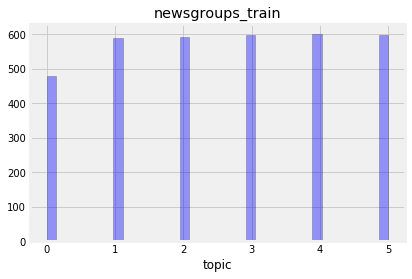

In [7]:
sns.distplot(newsgroups_train.target, hist=True, kde=False,
             bins=int(180/5), color = 'blue',
             hist_kws={'edgecolor':'black'})

plt.title('newsgroups_train')
plt.xlabel('topic')
plt.show()

/home/nasalsabila/anaconda3/envs/airy/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning:

The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.



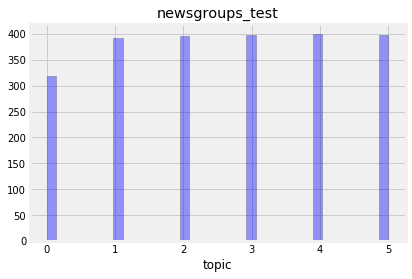

In [8]:
sns.distplot(newsgroups_test.target, hist=True, kde=False, 
             bins=int(180/5), color = 'blue',
             hist_kws={'edgecolor':'black'})

plt.title('newsgroups_test')
plt.xlabel('topic')
plt.show()

Frekuensi topik 1-5 (`comp.sys.ibm.pc.hardware`, `comp.windows.x`, `rec.sport.baseball`, `rec.sport.hockey`, `soc.religion.christian`) hampir sama, selisih dengan topik 0 (`alt.atheism`) sekitar 80-100 untuk kedua data train dan test. Kategori `rec.sport.hockey` merupakan kategori topik yang paling banyak.

#### Contoh isi dokumen

In [9]:
print ("-Kagetori:")
print(newsgroups_train.target_names[newsgroups_train.target[2]]) #mencetak kategori paling pertama

print ("\n\n-Isi: ")

print("\n".join(newsgroups_train.data[2].split("\n"))) #mencetak isi paling pertama

-Kagetori:
alt.atheism


-Isi: 

Bobby-

A few posts ago you said that Lucifer had no free will.  From the above
it seems the JW believes the contrary.

Are you talking about the same Lucifer?

If so, can you suggest an experiment to determine which of you is wrong?

Or do you claim that you are both right?


#### Kata yang sering muncul

In [10]:
from sklearn.feature_extraction.text import CountVectorizer

def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

common_words = get_top_n_words(newsgroups_train.data, 20)
for word, freq in common_words:
    print(word, freq)

the 32681
to 16064
of 13528
and 11976
is 10485
in 9525
that 9131
it 7092
for 5747
you 5344
this 4786
be 4555
not 4402
on 4339
are 4083
have 4080
with 3814
as 3785
but 3389
if 3295


Stop words! Mari kita buang stop words-nya.

In [11]:
from sklearn.feature_extraction.text import CountVectorizer

def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

common_words = get_top_n_words(newsgroups_train.data, 20)
for word, freq in common_words:
    print(word, freq)



god 1518
like 1189
don 1171
just 1140
does 1090
think 1055
know 1047
people 1038
time 1002
use 886
good 845
edu 808
new 721
way 704
year 696
10 694
team 681
game 661
say 657
file 645


### Membuat vektor dokumen

Selanjutnya kita membuat dokumen pada `newsgroups_train` dan `newsgroups_test` menjadi vektor dokumen menggunakan TF-IDF. 

In [12]:
vectorizer = TfidfVectorizer(stop_words='english')
X_train = vectorizer.fit_transform(newsgroups_train.data)
X_test = vectorizer.transform(newsgroups_test.data)
y_train = newsgroups_train.target
y_test = newsgroups_test.target

Dimensi vektor yang dihasilkan dari hasil ekstraksi dengan TF-IDF adalah:

In [13]:
print ("newsgroups_train = {}".format(X_train.shape[1]))
print ("newsgroups_test = {}".format(X_train.shape[1]))

newsgroups_train = 33324
newsgroups_test = 33324


Meski TF-IDF juga akan menghasilkan sparse matrix, tapi ada proses normalisasi yang dilakukan dengan menghitung *inverse document frequency*

In [14]:
X_train.shape

(3459, 33324)

In [15]:
# vectorizer.vocabulary_

## k-Nearest Neighbours

Pada bagian ini kita mengimplementasikan algoritma k-Nearest Neighbours dan akan melihat efek dari menggunakan metode penghitungan jarak yang berbeda.

### Klasifikasi 

Bagaimana hasil klasifikasi data uji menggunakan  $k \in [1, 15]$?

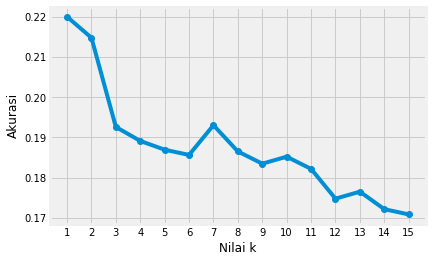

In [16]:
acc = []
for k in range (1, 16):
    clf = KNeighborsClassifier(n_neighbors=k)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test) 

    acc.append(accuracy_score(y_test, y_pred))
    
plt.plot(range(1,16), acc, 'o-')
plt.xticks(range(1,16), range(1,16))
plt.xlabel('Nilai k')
plt.ylabel('Akurasi')
plt.show()

Dari plot tersebut, nilai $k$ yang dipilih adalah 1 karena akurasinya paling tinggi. Kita bisa memilih nilai $k$ dengan melihat hasil metric yang terbaik.

Selanjutnya, dari nilai $k$ yang sudah dipilih, kita membuat *heatmap* dari *confusion matrix*-nya.

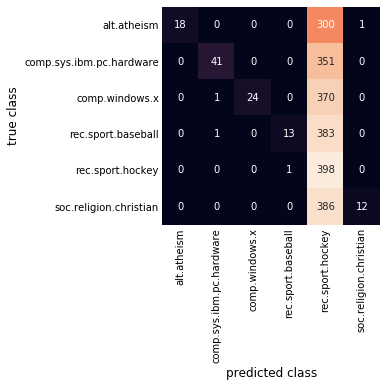

In [17]:
k = 1
clf = KNeighborsClassifier(n_neighbors=k)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test) 

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=newsgroups_test.target_names,
            yticklabels=newsgroups_test.target_names)
plt.xlabel('predicted class')
plt.ylabel('true class');

Berdasarkan hasil klasifikasi dan confusion matrix-nya, dapat disimpulkan sementara bahwa akurasinya kecil sekali dan memang terdapat banyak kesalahan prediksi. 
Misalnya, `alt.atheism` yang diprediksi sebagai `rec.sport.hockey` banyak sekali, yaitu 300 salah prediksi.
Jumlah kesalahan prediksinya lebih banyak dibandingkan jumlah prediksi yang benar, yaitu yang prediksinya benar sejumlah 506 (hasil penjumlahan diagonal).
Hasil prediksinya banyak yang ke kategori `rec.sport.hockey`. Berarti, error banyak disebabkan oleh memprediksi berbagai kategori sebagai `rec.sport.hockey` dibandingkan kategori yang lain.

### Pengaruh reduksi dimensi

Salah satu cara untuk mendapatkan makna tersirat dari kumpulan kata-kata yang ada adalah dengan menerapkan *Latent Semantic Analysis*. Hal ini dapat dilakukan dengan menggunakan `TruncatedSVD` dari scikit-learn. Kita akan menghasilkan vektor 100-dimensi untuk `X_train` dan `X_test` dengan `TruncatedSVD`.

In [18]:
svd = TruncatedSVD(n_components=100, random_state=RANDOM_STATE)
X_train = svd.fit_transform(X_train) 
X_test = svd.transform(X_test) 

Setelah itu kita akan melakukan hal yang sama seperti sebelumnya, yaitu klasfikiasi menggunakan algoritma k-NN dengan nilai $k \in [1,15]$. Apakah akurasinya berubah?

In [19]:
# for k in range (1, 16):
#     clf = KNeighborsClassifier(n_neighbors=k)
#     clf.fit(X_train, y_train)
#     y_pred = clf.predict(X_test) 

#     print ("Accuracy: %.4f" % accuracy_score(y_test, y_pred))

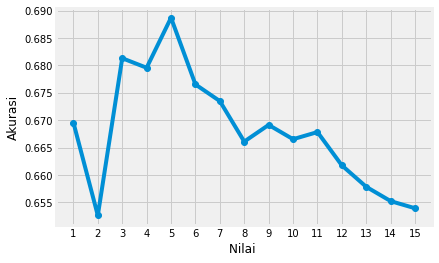

In [20]:
acc = []
for k in range (1, 16):
    clf = KNeighborsClassifier(n_neighbors=k)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test) 

    acc.append(accuracy_score(y_test, y_pred))
    
plt.plot(range(1,16), acc, 'o-')
plt.xticks(range(1,16), range(1,16))
plt.xlabel('Nilai ')
plt.ylabel('Akurasi')
plt.show()

Kali ini nilai $k$ yang terbaik adalah 5! 

Ayo gambarkan lagi *heatmap* dari *confusion matrix* dengan $k$ terbaik!

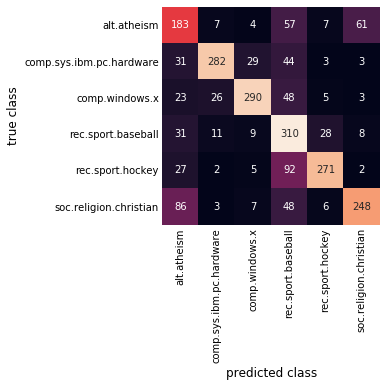

In [21]:
k = 5
clf = KNeighborsClassifier(n_neighbors=k)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test) 

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=newsgroups_test.target_names,
            yticklabels=newsgroups_test.target_names)
plt.xlabel('predicted class')
plt.ylabel('true class');

Wah, ternyata lebih bisa memprediksi dengan benar!

### Prediksi `talk.religion.misc`

Kita akan memprediksi kategori `talk.religion.misc` dengan model terbaik yang telah didapat.

In [22]:
kategori = ['talk.religion.misc']
Z = fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'), categories=kategori)

In [23]:
from collections import Counter
# V_train = vectorizer.fit_transform(Z.data)
V_test = vectorizer.transform(Z.data)
# V_train = svd.fit_transform(V_train) 
V_test = svd.transform(V_test) 
clf = KNeighborsClassifier(n_neighbors=5, algorithm='brute')
clf.fit(X_train, y_train)
pred = clf.predict(V_test)
print ("Akurasi: {}".format(accuracy_score(Z.target, pred)))
count = Counter()
for i in pred:
    count[i] += 1

print ("Hasil prediksi:\n")
for key, value in count.items():
    print ("Topik {}: {}".format(key, value))

Akurasi: 0.41832669322709165
Hasil prediksi:

Topik 0: 105
Topik 1: 3
Topik 2: 4
Topik 3: 44
Topik 4: 14
Topik 5: 81


Hasil prediksi yang dihasilkan ternyata `talk.religion.misc` paling banyak diprediksi sebagai kategori atheism. Hasilnya seperti itu karena sama-sama berhubungan dengan religion, jadi cukup mirip. 

Kesimpulan sementara?

Dengan menerapkan Latent Semantic Analysis, hasil prediksinya jadi lebih baik. Banyak terjadi kesalahan prediksi, yaitu banyak yang diprediksi sebagai kategori `rec.sport.hockey`.

## k-Means

`X_train` ditransformasikan dengan `TruncatedSVD` ke dalam dua dimensi. Berikut adalah gambar *scatter plot* dengan warna yang berbeda untuk masing-masing kategori/kelas.

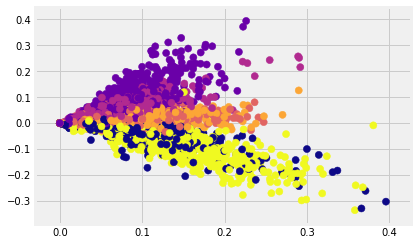

In [24]:
svd = TruncatedSVD(random_state=RANDOM_STATE) #n_components-nya sudah default 2
X = svd.fit_transform(X_train)
plt.scatter(X[:, 0], X[:, 1], c=newsgroups_train.target, s=50, cmap='plasma');

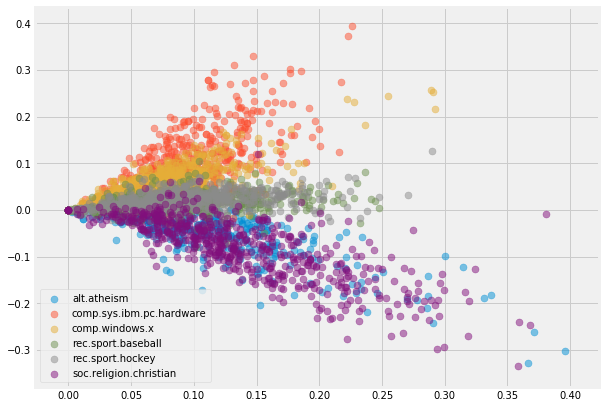

In [25]:
fig, ax = plt.subplots(figsize=(9, 7))
for category, group in zip(np.unique(newsgroups_train.target), newsgroups_train.target_names):
    mask = np.where(newsgroups_train.target == category)
    ax.scatter(X[mask,0], X[mask,1], alpha=0.5, label=group, s=50, cmap='plasma')
plt.legend()
plt.show()

### Clustering

Selanjutnya kita melakukan *clustering* dengan algoritma k-Means untuk menghasilkan 3 klaster dari hasil penerapan PCA (`TruncatedSVD`) pada `X_train`. 

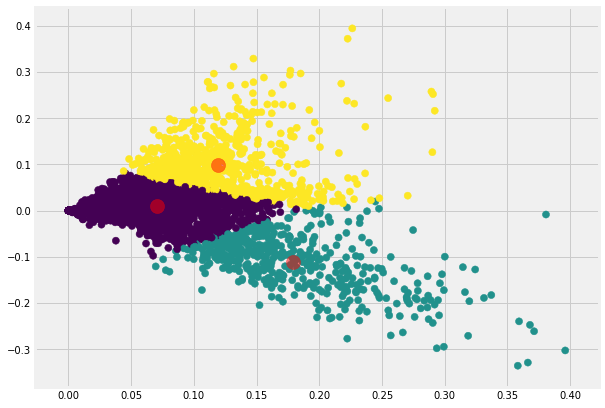

In [26]:
kmeans = KMeans(n_clusters=3, random_state=RANDOM_STATE)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

fig, ax = plt.subplots(figsize=(9, 7))
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50)

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], s=200, c='red', alpha=0.5, cmap='plasma');

Dari gambar yang dihasilkan, masing-masing kategori sepertinya memiliki banyak suatu ciri yang mirip, karena hampir menyatu dan sangat berdekatan seperti itu. Untuk clustering dengan algoritma k-Meansnya yang tadinya berbeda kelas, jadi menyatu. Benar-benar dilihat dari jarak yang berdekatan.  

Hasil klasternya sesuai yang diharapkan kah?

Mari lakukan clustering lagi, tetapi jumlah klaster diubah menjadi 6.

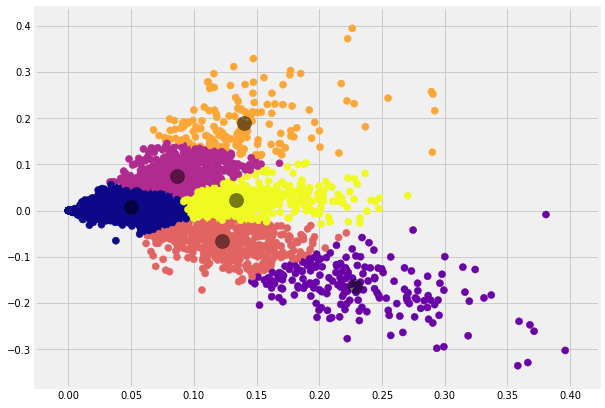

In [27]:
kmeans = KMeans(n_clusters=6, random_state=RANDOM_STATE)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)

fig, ax = plt.subplots(figsize=(9, 7))

plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='plasma')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], s=200, c='black', alpha=0.5);

Yang digarisbawahi adalah perbedaan klaster (yang jumlahnya sudah disamakan dengan jumlah kelas) dengan grup berdasarkan kelas yang sebenarnya

### Pengaruh reduksi dimensi

Kali ini, kita ingin melihat pengaruh reduksi dimensi terhadap hasil *clustering*. Nilai yang digunakan adalah `[1,2,3,5,10,20,50,100]` sebagai parameter `n_components` dari `TruncatedSVD`, kemudian menjalankan k-Means dengan 6 klaster untuk masing-masing data yang sudah direduksi tersebut. 


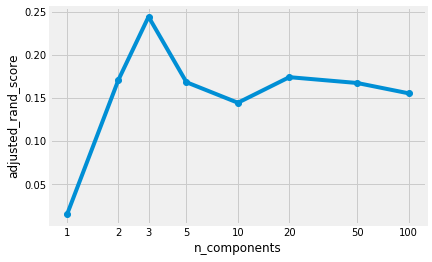

In [28]:
# mengulang kembali transformasi menjadi vektor dokumennya 
#(karena variabel X_train sebelumnya sudah dipakai untuk yang 100 component, dan jika n-nya 100 jadi tidak bisa)
X_train = vectorizer.fit_transform(newsgroups_train.data)
X_test = vectorizer.transform(newsgroups_test.data)
y_train = newsgroups_train.target
y_test = newsgroups_test.target


i = []
ars = []
nilai = [1, 2, 3, 5, 10, 20, 50, 100]
for n in nilai:
    svd = TruncatedSVD(n_components = n, random_state=RANDOM_STATE)
    X = svd.fit_transform(X_train)
    y = newsgroups_train.target
    kmeans = KMeans(n_clusters=6, random_state=RANDOM_STATE)
    kmeans.fit(X)
    y_kmeans = kmeans.predict(X)
    
    i.append(kmeans.inertia_)
    ars.append(adjusted_rand_score(y, y_kmeans))

plt.plot(np.log(nilai), ars, 'o-')
plt.xticks(np.log(nilai), nilai)
plt.xlabel('n_components')
plt.ylabel('adjusted_rand_score')
plt.show()

Line plot di atas menjelaskan nilai ARI untuk masing-masing n_components yang berbeda. Ternyata hasil terbaik adalah yang n_components-nya 3.

In [29]:
# # nilai inertia_
# print ("Nilai inersia: \n")
# for x in i:
#     print (x)

Yang ditunjukkan dari nilai `adjusted_rand_score`(ARI) adalah kesamaan antara dua clusterings.

Selanjutnya, data `X_train` diproyeksikan ke dalam $n$ _principal components_ yang menghasilkan ARI terbaik. Lalu, kita membuat _scree plot_ dari algoritma k-Means dengan nilai $k \in [1,12]$. Mari lihat nilai $k$ terbaik berdasarkan _scree plot_ tersebut!

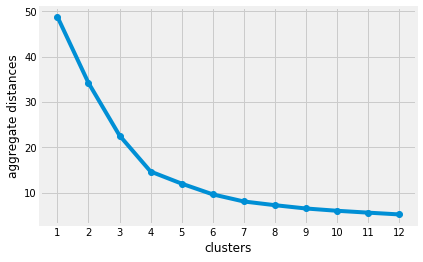

In [30]:
svd = TruncatedSVD(n_components=3, random_state=RANDOM_STATE)
X = svd.fit_transform(X_train)
y = newsgroups_train.target
v = []
for k in range(1,13):
    kmeans = KMeans(n_clusters=k, random_state=RANDOM_STATE)
    kmeans.fit(X)
    v.append(kmeans.inertia_)

plt.plot(range(1,13), v, 'o-')
plt.xticks(range(1,13), range(1,13))
plt.xlabel('clusters')
plt.ylabel('aggregate distances')
plt.show()

Dari hasil gambar scree plot diketahui jaraknya berkurang terus seiring bertambahnya cluster dan yang terbaik kira-kira $k$-nya 4.

Jumlah klaster terbaik berdasarkan scree plot ternyata tidak sama dengan jumlah kelas sebenarnya. Jadi, k-Means tidak menjamin didapatkannya jumlah klaster optimal dalam kasus ini.


Yak! Terima kasih! Dadaaaahhh!